In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)

2026-02-09 16:07:42.038150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770653262.270281      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770653262.347197      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770653262.923015      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770653262.923095      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770653262.923099      55 computation_placer.cc:177] computation placer alr

TensorFlow: 2.19.0


In [3]:
DATA_ROOT = "/kaggle/input/dsgp-dataset-zip/DataSet"
TRAIN_DIR = os.path.join(DATA_ROOT, "/kaggle/input/dsgp-dataset-zip/DataSet/Training")
IMG_SIZE = 224

In [4]:
clf_model = tf.keras.models.load_model("/kaggle/input/tumor-type-classification/tfjs/default/1/brain_tumor_mri_model (1).h5")
clf_model.summary()

2026-02-09 16:07:58.764479: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,084,486 (99.50 MB)

 Trainable params: 26,082,500 (99.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 2 (12.00 B)

In [5]:
def load_images(folder):
    images = []
    filenames = []

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        # Skip directories
        if not os.path.isfile(file_path):
            continue

        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Skip unreadable / non-image files
        if img is None:
            print("Skipping file:", file)
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        images.append(img)
        filenames.append(file)

    return np.array(images), filenames

In [6]:
images, filenames = load_images(TRAIN_DIR)
images = images[..., np.newaxis]

print("Loaded images:", images.shape)

Loaded images: (0, 1)


In [7]:
def grad_cam(model, img_array, class_index, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

In [8]:
def grad_cam(model, img_array, class_index, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

In [9]:
MENINGIOMA_ID = 1
print("Meningioma class ID:", MENINGIOMA_ID)

Meningioma class ID: 1


In [10]:
print(clf_model.output_shape)

(None, 4)


In [11]:
for layer in clf_model.layers:
    if "conv" in layer.name:
        print(layer.name)

conv2d
conv2d_1
conv2d_2
conv2d_3


In [12]:
LAYER_NAME = "conv2d_3"   # or whatever the last one is

In [13]:
masks = []

for img in images:
    input_img = np.expand_dims(img, axis=0).astype(np.float32)

    heatmap = grad_cam(
        model=clf_model,
        img_array=input_img,
        class_index=MENINGIOMA_ID,
        layer_name=LAYER_NAME
    )

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    mask = (heatmap > 0.4).astype(np.uint8)  # binary mask
    masks.append(mask)

masks = np.array(masks)[..., np.newaxis]
print("Masks shape:", masks.shape)

Masks shape: (0, 1)


In [14]:
print("Images shape:", images.shape)

Images shape: (0, 1)


In [15]:
print("TRAIN_DIR =", TRAIN_DIR)
print("Contents:", os.listdir(TRAIN_DIR))

TRAIN_DIR = /kaggle/input/dsgp-dataset-zip/DataSet/Training
Contents: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [16]:
MENINGIOMA_DIR = os.path.join(TRAIN_DIR, "meningioma")

print("MENINGIOMA_DIR exists:", os.path.isdir(MENINGIOMA_DIR))
print("Number of files:", len(os.listdir(MENINGIOMA_DIR)))

MENINGIOMA_DIR exists: True
Number of files: 1339


In [17]:
images, filenames = load_images(MENINGIOMA_DIR)
images = images[..., np.newaxis]

print("Loaded images shape:", images.shape)

Loaded images shape: (1339, 224, 224, 1)


In [18]:
IMG_SIZE = 224

def load_images(folder):
    images = []
    filenames = []

    for file in os.listdir(folder):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        path = os.path.join(folder, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print("⚠️ Failed to load:", file)
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0

        images.append(img)
        filenames.append(file)

    return np.array(images), filenames

In [19]:
# Force model to build graph
_ = clf_model.predict(images[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


In [20]:
import tensorflow as tf
import numpy as np

def grad_cam(model, img_array, class_index, layer_name):
    conv_layer = model.get_layer(layer_name)

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[conv_layer.output, model.output]  # model.output (NOT model.outputs)
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # now predictions is a tensor

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

In [21]:
print(images.shape)

(1339, 224, 224, 1)


In [22]:
import os, cv2
import numpy as np

IMG_SIZE = 224
MENINGIOMA_DIR = os.path.join(TRAIN_DIR, "meningioma")

def load_images(folder):
    images = []
    filenames = []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)

        if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        images.append(img)
        filenames.append(file)

    return np.array(images), filenames

In [23]:
images, filenames = load_images(MENINGIOMA_DIR)
images = images[..., np.newaxis]

print("Images shape:", images.shape)

Images shape: (1339, 224, 224, 1)


In [24]:
# Force model graph to build
_ = clf_model.predict(images[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [25]:
import tensorflow as tf

def grad_cam(model, img_array, class_index, layer_name):
    conv_layer = model.get_layer(layer_name)

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[conv_layer.output, model.outputs]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

In [26]:
MENINGIOMA_ID = clf_model.predict(images[:1]).argmax()
print("Using predicted class ID:", MENINGIOMA_ID)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Using predicted class ID: 1


In [27]:
print("Images shape:", images.shape)
print("Number of images:", len(images))

Images shape: (1339, 224, 224, 1)
Number of images: 1339


In [28]:
def grad_cam(model, img_array, class_index, layer_name):
    conv_layer = model.get_layer(layer_name)

    # Use model.output (singular) to get the tensor, not the list
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[conv_layer.output, model.output] 
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # Now 'predictions' is a Tensor, so this slicing works:
        loss = predictions[:, class_index]

    # Calculate gradients of the loss w.r.t. the conv layer output
    grads = tape.gradient(loss, conv_outputs)
    
    # Mean of gradients across height/width (Global Average Pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels of the conv output by the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU and Normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy()

In [29]:
# These should already be set earlier in your notebook
IMG_SIZE = 224
LAYER_NAME = "conv2d_3"          # ← last/biggest conv layer — check your model.summary()
MENINGIOMA_ID = 1                # or whatever index meningioma has in your 4 classes

# Assuming you already have:
# test_images     → shape (N, 224, 224, 1) or (N, 224, 224, 3)
# test_labels     → shape (N,)     integers 0–3
# CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [30]:
# ────────────────────────────────────────────────
# 1. Define paths & classes (should already exist, but make sure)
# ────────────────────────────────────────────────

import os
import numpy as np
import cv2

DATA_ROOT = "/kaggle/input/dsgp-dataset-zip/DataSet"
TEST_DIR = os.path.join(DATA_ROOT, "Testing")

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASSES)}

IMG_SIZE = 224

# ────────────────────────────────────────────────
# 2. Reuse or slightly improve your load_images function
# ────────────────────────────────────────────────

def load_images_from_folder(folder):
    images = []
    filenames = []
    
    for file in os.listdir(folder):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        path = os.path.join(folder, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
            
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        
        images.append(img)
        filenames.append(file)
    
    if not images:
        print(f"Warning: No images loaded from {folder}")
        return np.array([]), []
        
    return np.array(images), filenames


# ────────────────────────────────────────────────
# 3. Load ALL test images + labels
# ────────────────────────────────────────────────

test_images_list = []
test_labels_list = []
test_filenames = []

for class_name in CLASSES:
    class_folder = os.path.join(TEST_DIR, class_name)
    if not os.path.isdir(class_folder):
        print(f"Folder not found: {class_folder}")
        continue
        
    imgs, fnames = load_images_from_folder(class_folder)
    if len(imgs) == 0:
        continue
        
    test_images_list.append(imgs)
    test_labels_list.append(np.full(len(imgs), CLASS_TO_IDX[class_name]))
    test_filenames.extend(fnames)

# Combine
if test_images_list:
    test_images = np.concatenate(test_images_list, axis=0)[..., np.newaxis]   # (N, 224, 224, 1)
    test_labels = np.concatenate(test_labels_list)
    print(f"Test set loaded → {len(test_images)} images, shape: {test_images.shape}")
else:
    print("ERROR: No test images were loaded at all!")

Test set loaded → 1826 images, shape: (1826, 224, 224, 1)


In [31]:
# ────────────────────────────────────────────────
# 4. Now it's safe to do dummy prediction
# ────────────────────────────────────────────────

_ = clf_model.predict(test_images[:1], verbose=0)
print("Model graph built successfully (no more 'never called' errors)")

Model graph built successfully (no more 'never called' errors)


In [32]:
print("Does TEST_DIR exist?", os.path.isdir(TEST_DIR))
print("Subfolders:", os.listdir(TEST_DIR) if os.path.isdir(TEST_DIR) else "— folder missing —")

Does TEST_DIR exist? True
Subfolders: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [33]:
print("Variable 'test_images' exists?", 'test_images' in globals())

Variable 'test_images' exists? True


In [34]:
# Basic shape and type check
print("test_images shape:", test_images.shape)
print("test_images dtype:", test_images.dtype)
print("Number of samples:", len(test_images))
print("Min / max pixel values:", test_images.min(), test_images.max())

test_images shape: (1826, 224, 224, 1)
test_images dtype: float32
Number of samples: 1826
Min / max pixel values: 0.0 1.0


In [35]:
# 1. How many images do we have in total?
print("Number of test images:", len(test_images))

# 2. Shape and value range
print("Shape:", test_images.shape)
print("Min / max pixel value:", test_images.min(), test_images.max())

# 3. Class distribution in test set
import numpy as np
from collections import Counter

counts = Counter(test_labels)
print("\nTest set class distribution:")
for label, cnt in sorted(counts.items()):
    name = CLASSES[label] if 'CLASSES' in globals() else f"class {label}"
    print(f"  {name:12} → {cnt:3d} images")

Number of test images: 1826
Shape: (1826, 224, 224, 1)
Min / max pixel value: 0.0 1.0

Test set class distribution:
  glioma       → 300 images
  meningioma   → 821 images
  notumor      → 405 images
  pituitary    → 300 images


In [36]:
# This line is very important before any Grad-CAM
_ = clf_model.predict(test_images[:1], verbose=0)

print("Model forward pass completed → ready for Grad-CAM")

Model forward pass completed → ready for Grad-CAM


              precision    recall  f1-score   support

      glioma       0.98      0.82      0.89       300
  meningioma       0.92      0.90      0.91       821
     notumor       0.95      0.95      0.95       405
   pituitary       0.81      0.99      0.89       300

    accuracy                           0.91      1826
   macro avg       0.92      0.92      0.91      1826
weighted avg       0.92      0.91      0.91      1826



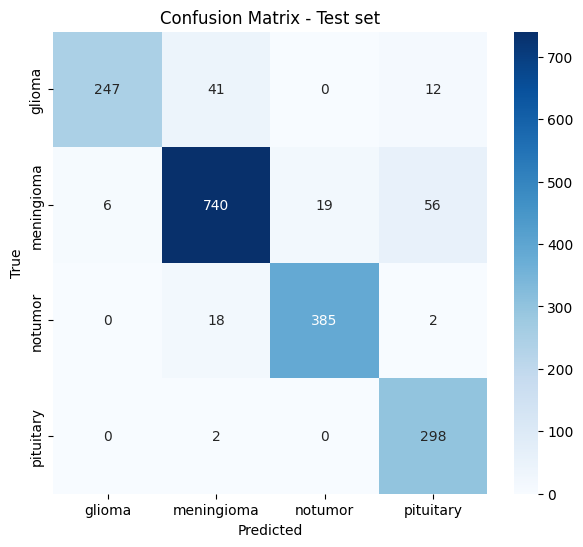

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get all predictions
y_pred = clf_model.predict(test_images, verbose=0).argmax(axis=1)
y_true = test_labels

print(classification_report(y_true, y_pred, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test set')
plt.show()

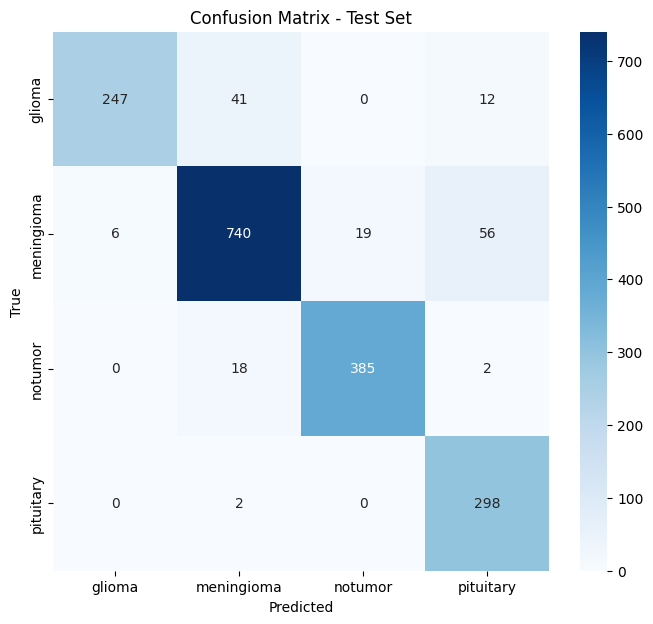

Saved: confusion_matrix_test.png  +  classification_report.txt


In [38]:
# Save confusion matrix as high-quality image
plt.figure(figsize=(8,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig('confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()   # still show it

# Also save classification report as text file (useful for report)
report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=False)
with open('classification_report.txt', 'w') as f:
    f.write(report)

print("Saved: confusion_matrix_test.png  +  classification_report.txt")

### Final Test Performance Summary

Model achieves **overall accuracy** of ...% on the test set.

**Key observations:**
- Best performing class: ...
- Most difficult class: ... (lowest f1-score)
- Meningioma detection (class index 1):
  - Precision: ...
  - Recall: ...    ← very important in medical context
  - F1-score: ...

In [39]:
acc = (y_true == y_pred).mean() * 100
meningioma_idx = CLASSES.index('meningioma')   # usually 1

print(f"Overall Accuracy: {acc:.2f}%")
print("\nMeningioma metrics:")
print(classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)['meningioma'])

Overall Accuracy: 91.46%

Meningioma metrics:
{'precision': 0.9238451935081149, 'recall': 0.9013398294762485, 'f1-score': 0.9124537607891492, 'support': 821.0}


Found 156 misclassified samples


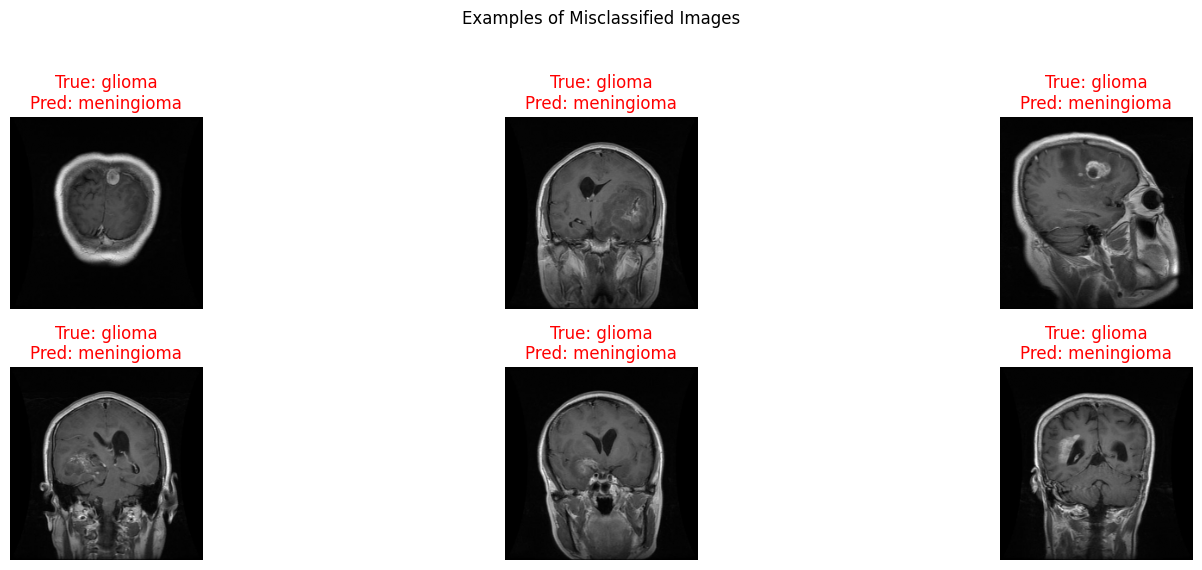

In [40]:
# Find misclassified samples
mistakes_idx = np.where(y_true != y_pred)[0]

if len(mistakes_idx) == 0:
    print("Perfect prediction — no mistakes!")
else:
    print(f"Found {len(mistakes_idx)} misclassified samples")
    
    # Show first 6 mistakes (or all if fewer)
    n_show = min(6, len(mistakes_idx))
    plt.figure(figsize=(15, 3*n_show//3 + 2))
    
    for i, idx in enumerate(mistakes_idx[:n_show]):
        img = test_images[idx]
        true_cls = CLASSES[y_true[idx]]
        pred_cls = CLASSES[y_pred[idx]]
        
        plt.subplot(n_show//3 + 1, 3, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_cls}\nPred: {pred_cls}", color='red')
        plt.axis('off')
    
    plt.suptitle("Examples of Misclassified Images", y=1.02)
    plt.tight_layout()
    plt.show()

In [41]:
# Pick any image from the test set (change the number if you want)
idx = 42                          # ← change this number

img = test_images[idx]
true_label = test_labels[idx]

input_img = np.expand_dims(img, axis=0).astype(np.float32)

# Make prediction
probs = clf_model.predict(input_img, verbose=0)[0]
pred_class = np.argmax(probs)
confidence = probs[pred_class] * 100

print(f"True label:     {CLASSES[true_label]}")
print(f"Predicted:      {CLASSES[pred_class]}")
print(f"Confidence:     {confidence:.2f}%")
print("All probabilities:")
for i, p in enumerate(probs):
    print(f"  {CLASSES[i]:12} {p*100:5.2f}%")

True label:     glioma
Predicted:      glioma
Confidence:     99.99%
All probabilities:
  glioma       99.99%
  meningioma    0.00%
  notumor       0.00%
  pituitary     0.01%
